In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from ipynb.fs.full.Functions import check_adf

os.chdir(r"C:\Users\tdrown\Documents\Blogs\Lead-Lag Blog")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

field_edge_file = r"C:\Users\tdrown\Documents\Blogs\Lead-Lag Blog\march field edge.xlsx"
contractor_hours_file = r"C:\Users\tdrown\Documents\Blogs\Lead-Lag Blog\Contractor Hours.xlsx"
contractor_payroll_file = r"C:\Users\tdrown\Documents\Blogs\Lead-Lag Blog\Contractor Payroll.xlsx"
mws_inv_file = r"C:\Users\tdrown\Documents\Blogs\Lead-Lag Blog\Monthly Wholesale Trade - Inventories.csv"
mws_sales_file = r"C:\Users\tdrown\Documents\Blogs\Lead-Lag Blog\Monthly Wholesale Trade - Sales.csv"
new_orders_file = r"C:\Users\tdrown\Documents\Blogs\Lead-Lag Blog\Manufacturers' Shipments, Inv, and Orders  - New Orders.csv" 
trends_file = r"C:\Users\tdrown\Documents\Blogs\Lead-Lag Blog\national_monthly_mediums_5.10.23.csv"

In [2]:
field_edge = pd.read_excel(field_edge_file, sheet_name='All Data')
hours = pd.read_excel(contractor_hours_file, skiprows=12)
payroll = pd.read_excel(contractor_payroll_file, skiprows=12)
mws_inv = pd.read_csv(mws_inv_file, skiprows=7)
mws_sales = pd.read_csv(mws_sales_file, skiprows=7)
new_orders = pd.read_csv(new_orders_file, skiprows=7)

month_map = pd.DataFrame({'Month': ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                          'Month Code': [1,2,3,4,5,6,7,8,9,10,11,12]})

#Clean
hours = pd.melt(hours, id_vars='Year')
hours.rename(columns={'variable': 'Month', 'value': 'hours'}, inplace=True)

payroll = pd.melt(payroll, id_vars='Year')
payroll.rename(columns={'variable': 'Month', 'value': 'payroll'}, inplace=True)

#Normalize index to time series
field_edge = field_edge[['Date', 'State', 'Region', 'NewCustomers', 'NewInvoices',
       'InvoiceTotal', 'NewQuotes', 'QuoteTotal', 'Month', 'Year',
       'AvgInvoice', 'AvgQuote']].copy()
field_edge = field_edge.loc[~field_edge['Region'].isin(['Canada', 'South America'])]
field_edge['Date'] = pd.to_datetime(field_edge['Date'])
field_edge.set_index('Date', inplace=True)

hours = hours.merge(month_map, how='left', on="Month")
payroll = payroll.merge(month_map, how='left',on='Month')

hours['Date'] = pd.to_datetime(hours['Year'].astype(str)+'-'+hours['Month Code'].astype(str), format='%Y-%m')
hours.set_index('Date', inplace=True)
hours= pd.DataFrame(hours[['hours']]).copy()
hours.sort_index(inplace=True)

payroll['Date'] = pd.to_datetime(payroll['Year'].astype(str)+'-'+payroll['Month Code'].astype(str), format='%Y-%m')
payroll.set_index('Date', inplace=True)
payroll = pd.DataFrame(payroll[['payroll']]).copy()
payroll.sort_index(inplace=True)

mws_inv['Month'] = mws_inv['Period'].str.split('-').str[0]
mws_inv = mws_inv.merge(month_map, how='left', on='Month')
mws_inv['Date'] = pd.to_datetime(mws_inv['Period'].str.split('-').str[1]+'-'+mws_inv['Month Code'].astype(str), format='%Y-%m')
mws_inv.set_index('Date', inplace=True)
mws_inv.sort_index(inplace=True)
mws_inv = pd.DataFrame(mws_inv[['Value']]).copy()
mws_inv.rename(columns={'Value': 'Inventory'}, inplace=True)

mws_sales['Month'] = mws_sales['Period'].str.split('-').str[0]
mws_sales = mws_sales.merge(month_map, how='left', on='Month')
mws_sales['Date'] = pd.to_datetime(mws_sales['Period'].str.split('-').str[1]+'-'+mws_sales['Month Code'].astype(str), format='%Y-%m')
mws_sales.set_index('Date', inplace=True)
mws_sales.sort_index(inplace=True)
mws_sales = pd.DataFrame(mws_sales[['Value']]).copy()
mws_sales.rename(columns={'Value': 'Sales'}, inplace=True)

new_orders['Month'] = new_orders['Period'].str.split('-').str[0]
new_orders = new_orders.merge(month_map, how='left', on='Month')
new_orders['Date'] = pd.to_datetime(new_orders['Period'].str.split('-').str[1]+'-'+new_orders['Month Code'].astype(str), format='%Y-%m')
new_orders.set_index('Date', inplace=True)
new_orders.sort_index(inplace=True)
new_orders = pd.DataFrame(new_orders[['Value']]).copy()
new_orders.rename(columns={'Value': 'New Orders'}, inplace=True)

mws = mws_sales.merge(mws_inv, how='inner', left_index=True, right_index=True)
mws = mws.merge(new_orders, how='left', left_index=True, right_index=True)
mws

C:\Users\tdrown\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\tdrown\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Sales,Inventory,New Orders
Date,,,
1992-01-01,3655.0,7034.0,NaN
1992-02-01,3650.0,7055.0,1996.0
1992-03-01,3621.0,7018.0,1979.0
1992-04-01,3773.0,7105.0,2300.0
1992-05-01,3700.0,7172.0,2186.0
1992-06-01,3726.0,7116.0,2208.0
1992-07-01,3748.0,7194.0,2023.0
1992-08-01,3627.0,7189.0,1968.0
1992-09-01,3664.0,7051.0,1990.0


fe
2019-01-01 00:00:00
2023-03-01 00:00:00
mws
1992-01-01 00:00:00
2023-12-01 00:00:00
hours
2013-01-01 00:00:00
2023-12-01 00:00:00
payroll
2013-01-01 00:00:00
2023-12-01 00:00:00
new_orders
1992-01-01 00:00:00
2023-12-01 00:00:00


<AxesSubplot:xlabel='Date'>

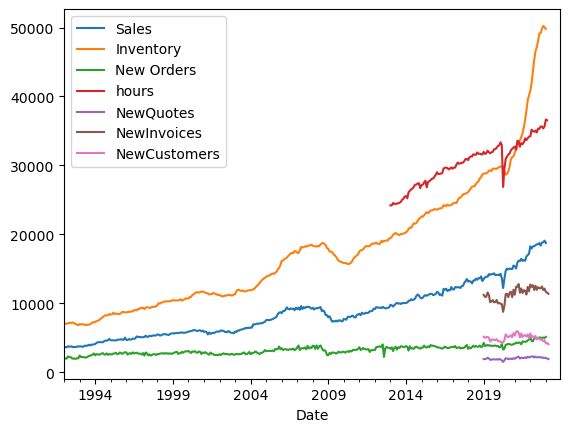

In [3]:
#Finsih Clean and combine to master dataframe
#Deseason Field Edge Data - New Quotes
fe = field_edge.groupby(field_edge.index)[['NewQuotes', 'NewInvoices', 'NewCustomers']].sum()
for col in fe.columns:    
    decomp = STL(fe[col]).fit()
    season = pd.DataFrame(decomp.seasonal)
    fe = fe.merge(season, how='left', on='Date')
    fe[col] = fe[col] - fe['season']
    fe = fe[['NewQuotes', 'NewInvoices', 'NewCustomers']].copy()


print_list = ['fe', 'mws', 'hours', 'payroll', 'new_orders']
i=0
for df in fe, mws, hours, payroll, new_orders:
    print(print_list[i])
    print(df.index.min())
    print(df.index.max())
    i=i+1
    
#Restrict dates to 2013-2023 year end

master = mws.copy()
master = master.merge(hours, how='left', left_index=True, right_index=True)
master = master.merge(payroll, how='left', left_index=True, right_index=True)
master = master.merge(fe, how='left', left_index=True, right_index=True)
master[['Sales', 'Inventory', 'New Orders', 'hours', 'NewQuotes',
       'NewInvoices', 'NewCustomers']].plot()

ADF Test:
ADF Statistic:-0.699888908116628
p-value:0.846778311090441
No. of Lags Used:4
Number of Obs:116
Fail to reject H0 thereby data is non-stationary
ADF Test:
ADF Statistic:1.063529031939952
p-value:0.9948930173196819
No. of Lags Used:3
Number of Obs:117
Fail to reject H0 thereby data is non-stationary
ADF Test:
ADF Statistic:-7.854177193517488
p-value:5.498954932631427e-12
No. of Lags Used:3
Number of Obs:116
Reject null hypothesis and data is stationary
ADF Test:
ADF Statistic:-8.582363680926296
p-value:7.667249447055319e-14
No. of Lags Used:2
Number of Obs:117
Reject null hypothesis and data is stationary

Hours on Sales

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7897  , p=0.0988  , df_denom=80, df_num=1
ssr based chi2 test:   chi2=2.8944  , p=0.0889  , df=1
likelihood ratio test: chi2=2.8450  , p=0.0917  , df=1
parameter F test:         F=2.7897  , p=0.0988  , df_denom=80, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test

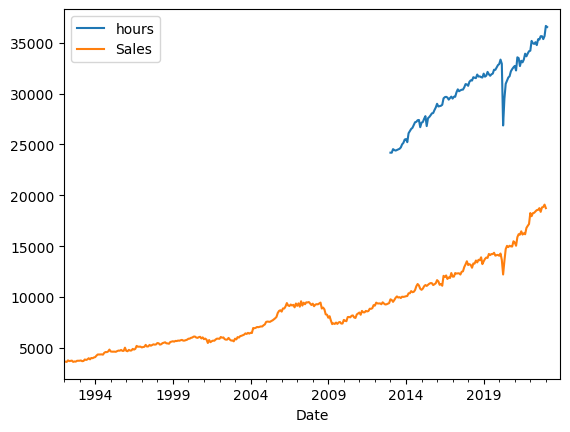

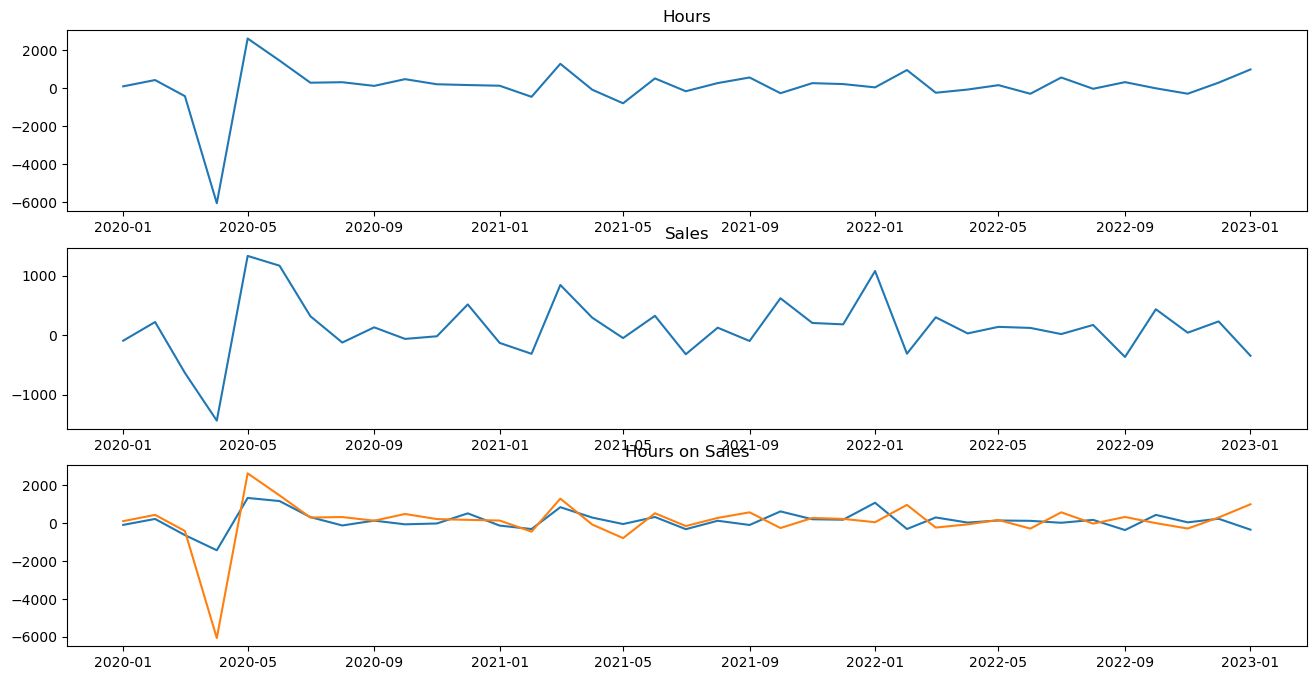

In [63]:
################################################TEST 1##########################################################################
#H0: hours does not granger-cause sales; HA: hours granger-caues sales
#Test 2
#H0: Sales does not granger cause hours; HA: sales granger-causes hours
master[['hours', 'Sales']].plot()
test1 = master[['hours', 'Sales']].copy()
test1.dropna(inplace=True)
for col in test1.columns:
    check_adf(test1[col])

test1['hours_diff1'] = test1.hours - test1.hours.shift(1)
check_adf(test1['hours_diff1'].dropna()) #Stationary now

test1['Sales_diff1'] = test1.Sales - test1.Sales.shift(1)
check_adf(test1['Sales_diff1'].dropna())

test1['sales_pct'] = ((test1.Sales_diff1/test1.Sales_diff1.shift(1)) - 1) * 100
test1['hours_pct'] = ((test1.hours_diff1/test1.hours_diff1.shift(1)) - 1) * 100

from statsmodels.tsa.stattools import grangercausalitytests as granger

#Hours on Sales
print("")
print("Hours on Sales")
granger(test1[['Sales_diff1', 'hours_diff1']].loc[test1.index <= '2020-01-01'].dropna(), maxlag=12, addconst=True)
print("")

#Sales on Hours
print("Sales on Hours")
granger(test1[['hours_diff1', 'Sales_diff1']].dropna(), maxlag=12, addconst=True)
test1

x = test1[test1.index>='2020-01-01'].copy()
fig, ax = plt.subplots(3,1, figsize=(16,8))
ax[0].plot(x['hours_diff1'], label='Hours')
ax[0].set_title('Hours')
ax[1].plot(x['Sales_diff1'], label='Sales')
ax[1].set_title('Sales')
ax[2].plot(x[['Sales_diff1', 'hours_diff1']])
ax[2].set_title('Hours on Sales')
plt.show()



ADF Test:
ADF Statistic:-0.6739815660132134
p-value:0.8533742935031818
No. of Lags Used:4
Number of Obs:117
Fail to reject H0 thereby data is non-stationary
ADF Test:
ADF Statistic:0.001071398458090444
p-value:0.9586206003270277
No. of Lags Used:6
Number of Obs:365
Fail to reject H0 thereby data is non-stationary
ADF Test:
ADF Statistic:1.4468630521463974
p-value:0.9973169735555873
No. of Lags Used:16
Number of Obs:356
Fail to reject H0 thereby data is non-stationary
ADF Test:
ADF Statistic:-10.772590238215743
p-value:2.3634582616752875e-19
No. of Lags Used:5
Number of Obs:365
Reject null hypothesis and data is stationary

Hours on New Orders

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8291  , p=0.0953  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=2.9022  , p=0.0885  , df=1
likelihood ratio test: chi2=2.8674  , p=0.0904  , df=1
parameter F test:         F=2.8291  , p=0.0953  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
s

{1: ({'ssr_ftest': (10.541830953176936, 0.0012744642553024457, 367.0, 1),
   'ssr_chi2test': (10.628003958243777, 0.0011138787905217225, 1),
   'lrtest': (10.47822423796606, 0.0012078980021069969, 1),
   'params_ftest': (10.541830953176955, 0.0012744642553024457, 367.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (7.048810877617689, 0.000992050354101377, 364.0, 2),
   'ssr_chi2test': (14.291270405719379, 0.0007882973410991092, 2),
   'lrtest': (14.021466149827575, 0.0009021470045928809, 2),
   'params_ftest': (7.048810877617678, 0.000992050354101377, 364.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (5.051933140983979, 0.001934125921764473, 361.0, 3),
   'ssr_chi2test': (15.449679190155988, 0.0014700337183868413, 3),
   'lrtest': (15.13416905955728, 0.0017055086871612763, 3),
   'params_ftest': (5.051933140983896, 0.0019341259217646482, 361.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0

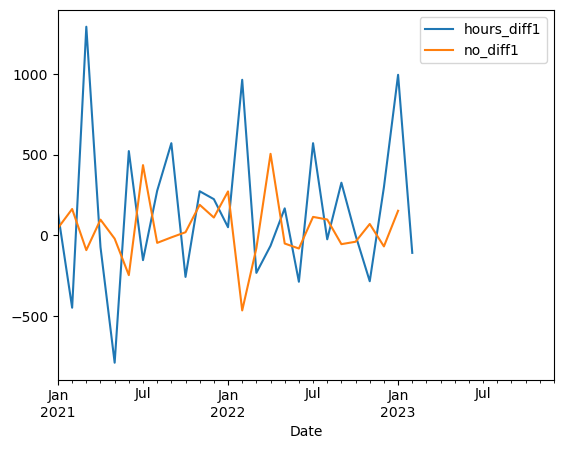

In [5]:
#Hours on New Orders
test2 = master[['hours', 'New Orders', 'Sales']].copy()
#Check hours on New orders and vice versa
#Check New orders on sales and vice versa

for col in test2.columns:
    check_adf(test2[col].dropna())
test2['hours_diff1'] = test2.hours - test2.hours.shift(1)
test2['Sales_diff1'] = test2.Sales - test2.Sales.shift(1)

test2['no_diff1'] = test2['New Orders'] - test2['New Orders'].shift(1)
check_adf(test2.no_diff1.dropna()) #Stationary

#Hours on New Orders
test2[['hours_diff1', 'no_diff1']].loc[test2.index>='2021-01-01'].plot()
print('')
print('Hours on New Orders')
granger(test2[['hours_diff1', 'no_diff1']].dropna(), maxlag=3)
print('')
print('New Orders on Hours')
granger(test2[['no_diff1', 'hours_diff1']].dropna(), maxlag=3)

#Since New Orders Granger Cause Hours, do New Orders Granger Cause Sales?
print('')
print('New Orders on Sales')
granger(test2[['no_diff1', 'Sales_diff1']].dropna(), maxlag=12) #Lol shocking that Sales goes up when orders goes up
#maybe useful for a lead time analysis at some point?

ADF Test:
ADF Statistic:1.4468630521463974
p-value:0.9973169735555873
No. of Lags Used:16
Number of Obs:356
Fail to reject H0 thereby data is non-stationary
ADF Test:
ADF Statistic:-0.6739815660132134
p-value:0.8533742935031818
No. of Lags Used:4
Number of Obs:117
Fail to reject H0 thereby data is non-stationary
ADF Test:
ADF Statistic:-2.5263581545184506
p-value:0.10919209777372635
No. of Lags Used:0
Number of Obs:50
Fail to reject H0 thereby data is non-stationary
ADF Test:
ADF Statistic:-1.5821951410100894
p-value:0.4925310110071865
No. of Lags Used:1
Number of Obs:49
Fail to reject H0 thereby data is non-stationary
ADF Test:
ADF Statistic:-0.9645512105044177
p-value:0.7659729351531624
No. of Lags Used:1
Number of Obs:49
Fail to reject H0 thereby data is non-stationary
ADF Test:
ADF Statistic:-1.5614549761743086
p-value:0.5029214515740283
No. of Lags Used:11
Number of Obs:38
Fail to reject H0 thereby data is non-stationary
ADF Test:
ADF Statistic:-5.218893026430707
p-value:8.0438989

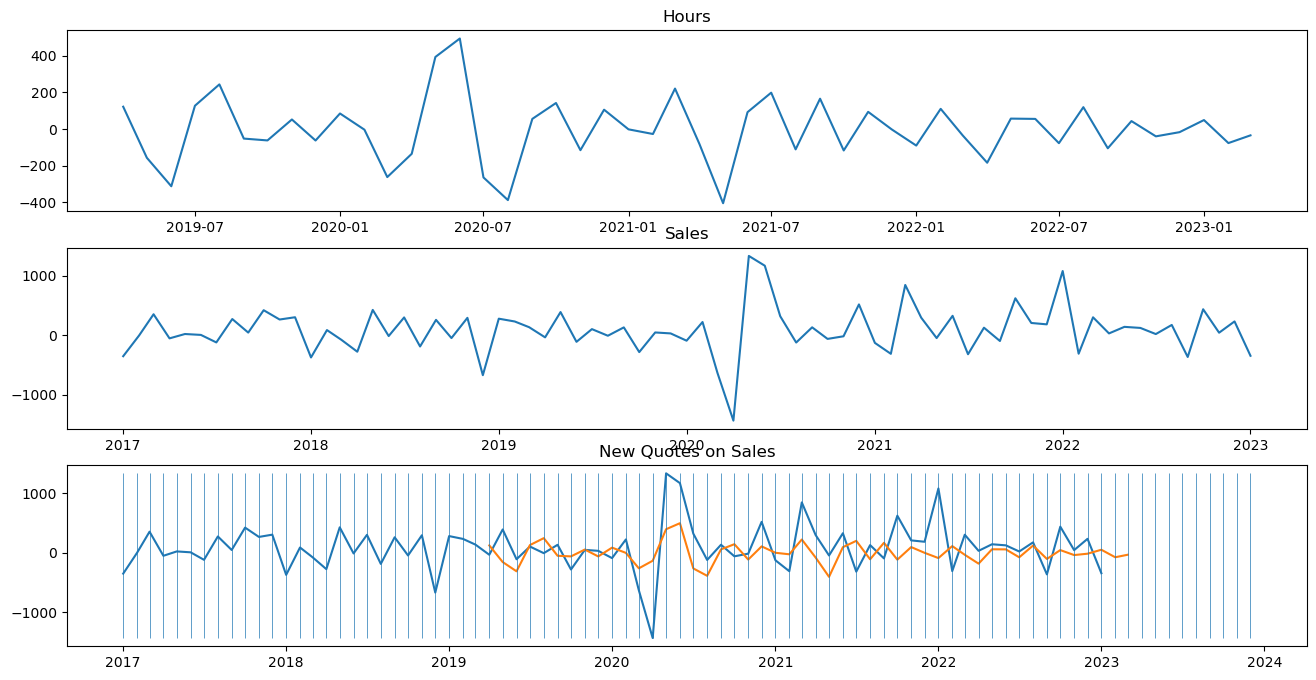

'\nx = test3.index[test3.index >=\'2019-01-01\'].copy()\ny1 = test3[\'Sales\']\ny2 = test3[\'NewQuotes\']\n\n# Plot Line1 (Left Y Axis)\nfig, ax1 = plt.subplots(1,1,figsize=(16,9), dpi= 80)\nax1.plot(x, y1, color=\'tab:red\')\n\n# Plot Line2 (Right Y Axis)\nax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis\nax2.plot(x, y2, color=\'tab:blue\')\n\n# Decorations\n# ax1 (left Y axis)\nax1.set_xlabel(\'Time\', fontsize=20)\nax1.tick_params(axis=\'x\', rotation=0, labelsize=12)\nax1.set_ylabel(\'Sales\', color=\'tab:red\', fontsize=20)\nax1.tick_params(axis=\'y\', rotation=0, labelcolor=\'tab:red\' )\nax1.grid(alpha=.4)\n\n# ax2 (right Y axis)\nax2.set_ylabel("New Quotes", color=\'tab:blue\', fontsize=20)\nax2.tick_params(axis=\'y\', labelcolor=\'tab:blue\')\nax2.set_xticks(np.arange(0, len(x), 60))\nax2.set_xticklabels(x[::60], rotation=90, fontdict={\'fontsize\':10})\nax2.set_title("MWS Trade vs New Quotes", fontsize=22)\nfig.tight_layout()\nplt.show()\n'

In [62]:
#Test 3 using feild edge indicators
fe.columns
master.columns
test3 = master[['Sales', 'hours', 'NewQuotes', 'NewInvoices', 'NewCustomers']].copy()

for col in test3.columns:
    check_adf(test3[col].dropna()) #All Non Stationary
    
test3['sales_diff1'] = test3.Sales - test3.Sales.shift(1)
test3['hours_diff1'] = test3.hours - test3.hours.shift(1)
test3['nq_diff1'] = test3.NewQuotes - test3.NewQuotes.shift(1)
test3['nq_diff2'] = (test3.NewQuotes - test3.NewQuotes.shift(1)) - (test3.NewQuotes.shift(2) - test3.NewQuotes.shift(3))
check_adf(test3.nq_diff1.dropna())
check_adf(test3.nq_diff2.dropna())#stationary now
test3['ni_diff1'] = test3.NewInvoices - test3.NewInvoices.shift(1)
test3['ni_diff2'] = (test3.NewInvoices - test3.NewInvoices.shift(1)) - (test3.NewInvoices.shift(2) - test3.NewInvoices.shift(3))
check_adf(test3['ni_diff2'].dropna())


print('\nNew Quotes on Sales\n')
granger(test3[['sales_diff1', 'nq_diff2']].dropna(), maxlag=3)
granger(test3[['sales_diff1', 'ni_diff2']].dropna(), maxlag=3)

print('\nSales on New Quotes\n')
granger(test3[['nq_diff2', 'sales_diff1']].dropna(), maxlag=3)
granger(test3[['ni_diff2', 'sales_diff1']].dropna(), maxlag=3)


x = test3[test3.index>='2020-01-01'].copy()
fig, ax = plt.subplots(3, figsize=(16,8))
ax[0].plot(x['nq_diff2'], label='Hours')
ax[0].set_title('Hours')
ax[1].plot(x['sales_diff1'], label='Sales')
ax[1].set_title('Sales')
ax[2].plot(x[['sales_diff1', 'nq_diff2']])
ax[2].set_title('New Quotes on Sales')

for xtick in x.index:
    ax[2].vlines(xtick, ymin=x.sales_diff1.min(), ymax=x.sales_diff1.max(), linewidth=0.5)
plt.show()
'''
x = test3.index[test3.index >='2019-01-01'].copy()
y1 = test3['Sales']
y2 = test3['NewQuotes']

# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(16,9), dpi= 80)
ax1.plot(x, y1, color='tab:red')

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:blue')

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Time', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('Sales', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("New Quotes", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_xticks(np.arange(0, len(x), 60))
ax2.set_xticklabels(x[::60], rotation=90, fontdict={'fontsize':10})
ax2.set_title("MWS Trade vs New Quotes", fontsize=22)
fig.tight_layout()
plt.show()
'''

In [7]:
trends = pd.read_excel(r"C:\Users\tdrown\Documents\Blogs\Lead-Lag Blog\national_monthly_medians_5.10.23.xlsx")
len(trends.index)
trends['date'] = pd.to_datetime(trends['date'])
trends.set_index('date', inplace=True)
trends.sort_index(inplace=True)
trends = trends.loc[trends.index>='2012-07-01'].copy()
trends.rename(columns={'national_monthly_median': 'trends'}, inplace=True)

check_adf(trends.trends)
#remove seasonality
decomp = STL(trends['trends']).fit()
season = pd.DataFrame(decomp.seasonal)
trends = trends.merge(season, how='left', on='date')
trends['deseason'] = trends['trends'] - trends['season']
check_adf(trends.deseason)
trends['diff1'] = trends.deseason - trends.deseason.shift(1)
check_adf(trends['diff1'].dropna())
trends['diff2'] = trends.diff1 - (trends.deseason.shift(2) - trends.deseason.shift(3))
check_adf(trends.diff2.dropna())

#test4 = test1.merge(trends, how='left', left_index=True, right_index=True)
test4 = trends.merge(test3, how='left', left_index=True, right_index=True)

print('\nHours on Trends\n')
granger(test4[['diff2', 'hours_diff1']].dropna(), maxlag=3)

print('\nTrends on Hours\n')
granger(test4[['hours', 'hours_diff1']].dropna(), maxlag=3)



ADF Test:
ADF Statistic:-1.0863752526650303
p-value:0.7204746011713457
No. of Lags Used:12
Number of Obs:116
Fail to reject H0 thereby data is non-stationary
ADF Test:
ADF Statistic:-1.3263534067623506
p-value:0.6170310315931279
No. of Lags Used:13
Number of Obs:115
Fail to reject H0 thereby data is non-stationary
ADF Test:
ADF Statistic:-1.4242359526215693
p-value:0.5706035396313133
No. of Lags Used:13
Number of Obs:114
Fail to reject H0 thereby data is non-stationary
ADF Test:
ADF Statistic:-3.697678015216207
p-value:0.004145933731753477
No. of Lags Used:12
Number of Obs:113
Reject null hypothesis and data is stationary

Hours on Trends


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1242  , p=0.7251  , df_denom=117, df_num=1
ssr based chi2 test:   chi2=0.1274  , p=0.7211  , df=1
likelihood ratio test: chi2=0.1273  , p=0.7212  , df=1
parameter F test:         F=0.1242  , p=0.7251  , df_denom=117, df_num=1

Granger Causality
number of lags (no zero) 2
ssr 

{1: ({'ssr_ftest': (5.0420293207143425, 0.02661775372571062, 117.0, 1),
   'ssr_chi2test': (5.1713121238095825, 0.022962865163445895, 1),
   'lrtest': (5.062986388428271, 0.02444208506493154, 1),
   'params_ftest': (5.042029320714465, 0.026617753725708987, 117.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.475214997859616, 0.013438897815231091, 115.0, 2),
   'ssr_chi2test': (9.261749299918161, 0.009746230832862156, 2),
   'lrtest': (8.919002306963193, 0.011568132571012869, 2),
   'params_ftest': (9.862503550160806, 0.00011139185822184697, 115.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.36361173191546914, 0.7793954884376576, 113.0, 3),
   'ssr_chi2test': (1.139102239805983, 0.767644005962983, 3),
   'lrtest': (1.1336392594569134, 0.7689602600939153, 3),
   'params_ftest': (6.845273363095482, 0.0002798538689727566, 113.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0

In [8]:
out1 = test1[['hours', 'Sales', 'hours_diff1', 'Sales_diff1']]
out2 = test3[['Sales','NewQuotes', 'sales_diff1', 'nq_diff2']]
out3 = test4[['trends', 'deseason', 'diff2', 'hours', 'hours_diff1']]
writer = pd.ExcelWriter('Output/output.xlsx')
#cnt_out.to_excel(writer, sheet_name=print_list[i])

out1.to_excel(writer, sheet_name='MWT Sales-Hours')
out2.to_excel(writer, sheet_name='Sales-NewQuotes')
out3.to_excel(writer, sheet_name='Trends-Hours')
writer.close()

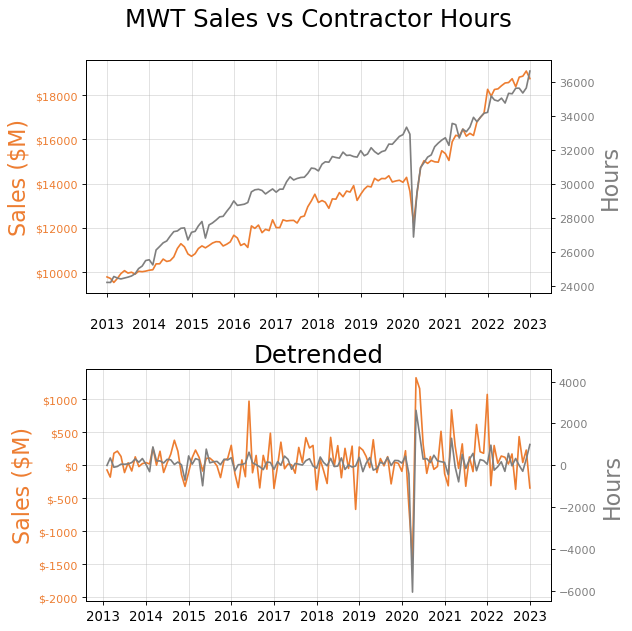

In [58]:
#Plot 1
import datetime
from matplotlib import dates as mdates
x = test1.index[test1.index >='2013-01-01'].copy()
y1 = test1['Sales']
y2 = test1['hours']

# Plot Line1 (Left Y Axis)
fig, (ax1, ax3) = plt.subplots(2,1,figsize=(8,8), dpi= 80)
ax1.plot(x, y1, color='#ED7D31')

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:grey')

# Decorations
# ax1 (left Y axis)
#ax1.set_xlabel('Time', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('Sales ($M)', color='#ED7D31', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='#ED7D31' )
ax1.grid(alpha=.4)
ax1.yaxis.set_major_formatter('${x:g}')

# ax2 (right Y axis)
ax2.set_ylabel("Hours", color='tab:grey', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:grey')
#ax2.set_xticks(np.arange(0, len(x), 121))
#ax2.set_xticklabels(labels, rotation=90, fontdict={'fontsize':10})

years = mdates.YearLocator()
yearsFmt = mdates.DateFormatter('\n%Y')
ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(yearsFmt)
ax2.set_title("MWT Sales vs Contractor Hours\n", fontsize=22)

#Plot 2
x = test1.index[test1.index >='2013-01-01'].copy()
y1 = test1['Sales_diff1']
y2 = test1['hours_diff1']

# Plot Line1 (Left Y Axis)
ax3.plot(x, y1, color='#ED7D31')

# Plot Line2 (Right Y Axis)
ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
ax4.plot(x, y2, color='tab:grey')

# Decorations
# ax1 (left Y axis)
#ax3.set_xlabel('Time', fontsize=20)
ax3.tick_params(axis='x', rotation=0, labelsize=12)
ax3.set_ylabel('Sales ($M)', color='#ED7D31', fontsize=20)
ax3.tick_params(axis='y', rotation=0, labelcolor='#ED7D31' )
ax3.grid(alpha=.4)
ax3.yaxis.set_major_formatter('${x:g}')

# ax2 (right Y axis)
ax4.set_ylabel("Hours", color='tab:grey', fontsize=20)
ax4.tick_params(axis='y', labelcolor='tab:grey')
ax4.set_title("Detrended", fontsize=22)

def align_yaxis(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = (ax1, ax2)
    extrema = [ax.get_ylim() for ax in axes]
    tops = [extr[1] / (extr[1] - extr[0]) for extr in extrema]
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [list(reversed(l)) for l in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    b_new_t = extrema[0][0] + tot_span * (extrema[0][1] - extrema[0][0])
    t_new_b = extrema[1][1] - tot_span * (extrema[1][1] - extrema[1][0])
    axes[0].set_ylim(extrema[0][0], b_new_t)
    axes[1].set_ylim(t_new_b, extrema[1][1])

align_yaxis(ax3,ax4)


fig.tight_layout()
plt.savefig('Output/MWS Sales vs Hours.png')
plt.savefig('Output/plot1.png')
plt.show()

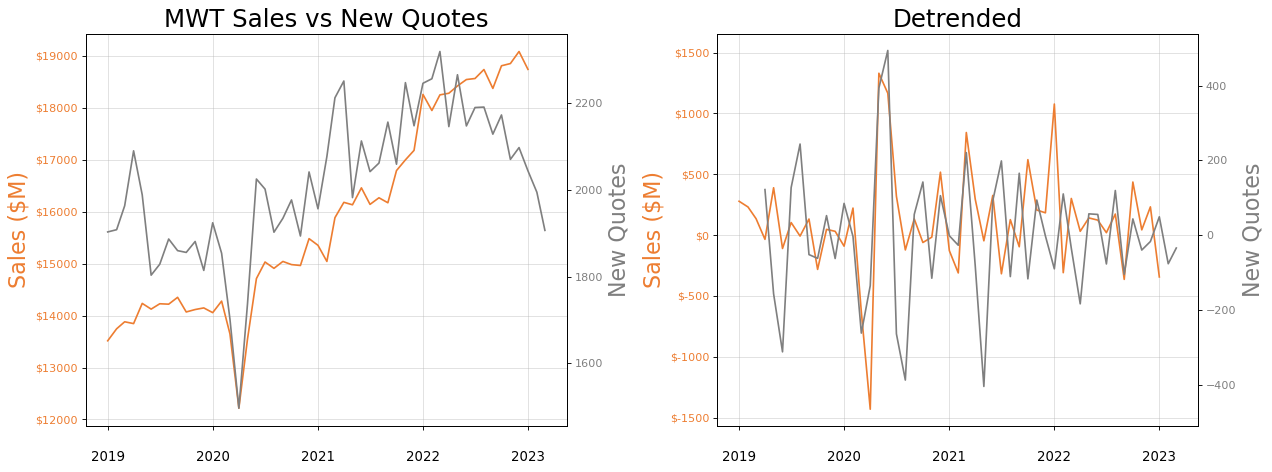

In [61]:
#Plot 2
x = test3.index[test3.index >='2019-01-01'].copy()
y1 = test3['Sales'].loc[test3.index >= '2019-01-01']
y2 = test3['NewQuotes'].loc[test3.index >= '2019-01-01']

# Plot Line1 (Left Y Axis)
fig, (ax1, ax3) = plt.subplots(1,2,figsize=(16,6), dpi= 80,sharex='row')
ax1.plot(x, y1, color='#ED7D31')

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:grey')

# Decorations
# ax1 (left Y axis)
#ax1.set_xlabel('Time', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('Sales ($M)', color='#ED7D31', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='#ED7D31' )
ax1.grid(alpha=.4)
ax1.yaxis.set_major_formatter('${x:g}')

# ax2 (right Y axis)
ax2.set_ylabel("New Quotes", color='tab:grey', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:grey')
#ax2.set_xticks(np.arange(0, len(x), 121))
#ax2.set_xticklabels(x[::121], rotation=90, fontdict={'fontsize':10})

years = mdates.YearLocator()
yearsFmt = mdates.DateFormatter('\n%Y')
ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(yearsFmt)
ax2.set_title("MWT Sales vs New Quotes", fontsize=22)

#Plot 2
x = test3.index[test3.index >='2019-01-01'].copy()
y1 = test3['sales_diff1'].loc[test3.index >= '2019-01-01']
y2 = test3['nq_diff2'].loc[test3.index >= '2019-01-01']

# Plot Line1 (Left Y Axis)
ax3.plot(x, y1, color='#ED7D31')

# Plot Line2 (Right Y Axis)
ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
ax4.plot(x, y2, color='tab:grey')

# Decorations
# ax1 (left Y axis)
#ax3.set_xlabel('Time', fontsize=20)
ax3.tick_params(axis='x', rotation=0, labelsize=12)
ax3.set_ylabel('Sales ($M)', color='#ED7D31', fontsize=20)
ax3.tick_params(axis='y', rotation=0, labelcolor='#ED7D31' )
ax3.grid(alpha=.4)
ax3.yaxis.set_major_formatter('${x:g}')
# ax2 (right Y axis)
ax4.set_ylabel("New Quotes", color='tab:grey', fontsize=20)
ax4.tick_params(axis='y', labelcolor='tab:grey')
#ax2.set_xticks(np.arange(0, len(x), 121))
#ax2.set_xticklabels(x[::121], rotation=90, fontdict={'fontsize':10})

years = mdates.YearLocator()
yearsFmt = mdates.DateFormatter('\n%Y')
ax4.xaxis.set_major_locator(years)
ax4.xaxis.set_major_formatter(yearsFmt)
ax4.set_title("Detrended", fontsize=22)

def align_yaxis(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = (ax1, ax2)
    extrema = [ax.get_ylim() for ax in axes]
    tops = [extr[1] / (extr[1] - extr[0]) for extr in extrema]
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [list(reversed(l)) for l in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    b_new_t = extrema[0][0] + tot_span * (extrema[0][1] - extrema[0][0])
    t_new_b = extrema[1][1] - tot_span * (extrema[1][1] - extrema[1][0])
    axes[0].set_ylim(extrema[0][0], b_new_t)
    axes[1].set_ylim(t_new_b, extrema[1][1])

align_yaxis(ax3,ax4)

fig.tight_layout()
plt.savefig('Output/MWS Sales vs New Quotes.png')
plt.savefig('Output/plot2.png')
plt.show()

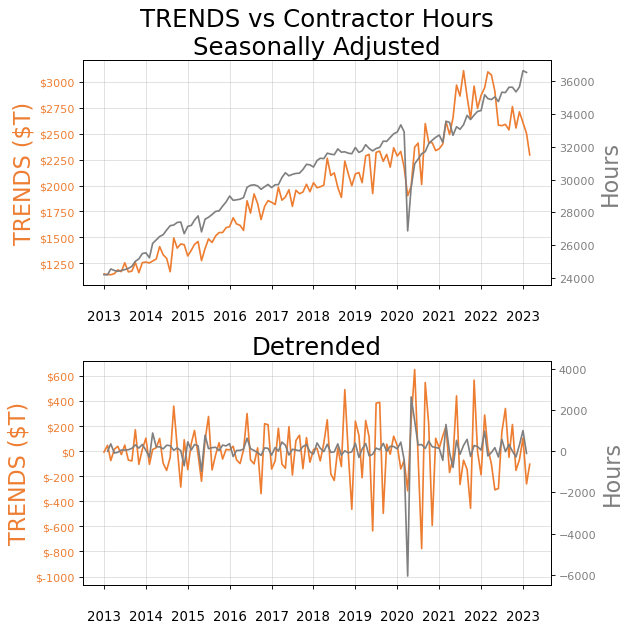

In [57]:
#Plot 3
import datetime
from matplotlib import dates as mdates
x = test4.index[test4.index >='2013-01-01'].copy()
y1 = test4['deseason'].loc[test4.index >= '2013-01-01']/1000
y2 = test4['hours'].loc[test4.index >= '2013-01-01']

# Plot Line1 (Left Y Axis)
fig, (ax1, ax3) = plt.subplots(2,1,figsize=(8,8), dpi= 80)
ax1.plot(x, y1, color='#ED7D31')

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:grey')

# Decorations
# ax1 (left Y axis)
#ax1.set_xlabel('Time', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('TRENDS ($T)', color='#ED7D31', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='#ED7D31' )
ax1.grid(alpha=.4)
ax1.yaxis.set_major_formatter('${x:g}')

# ax2 (right Y axis)
ax2.set_ylabel("Hours", color='tab:grey', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:grey')
#ax2.set_xticks(np.arange(0, len(x), 121))
#ax2.set_xticklabels(labels, rotation=90, fontdict={'fontsize':10})
years = mdates.YearLocator()
yearsFmt = mdates.DateFormatter('\n%Y')
ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(yearsFmt)
ax2.set_title("TRENDS vs Contractor Hours\nSeasonally Adjusted", fontsize=22)

#Plot 2
x = test4.index[test4.index >='2013-01-01'].copy()
y1 = test4['diff2'].loc[test4.index >= '2013-01-01'] / 1000
y2 = test4['hours_diff1'].loc[test4.index >= '2013-01-01']

# Plot Line1 (Left Y Axis)
ax3.plot(x, y1, color='#ED7D31')

# Plot Line2 (Right Y Axis)
ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
ax4.plot(x, y2, color='tab:grey')

# Decorations
# ax1 (left Y axis)
#ax3.set_xlabel('Time', fontsize=20)
ax3.tick_params(axis='x', rotation=0, labelsize=12)
ax3.set_ylabel('TRENDS ($T)', color='#ED7D31', fontsize=20)
ax3.tick_params(axis='y', rotation=0, labelcolor='#ED7D31' )
ax3.grid(alpha=.4)
ax3.yaxis.set_major_formatter('${x:g}')

# ax2 (right Y axis)
ax4.set_ylabel("Hours", color='tab:grey', fontsize=20)
ax4.tick_params(axis='y', labelcolor='tab:grey')
ax4.set_title("Detrended", fontsize=22)
years = mdates.YearLocator()
yearsFmt = mdates.DateFormatter('\n%Y')
ax4.xaxis.set_major_locator(years)
ax4.xaxis.set_major_formatter(yearsFmt)

def align_yaxis(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = (ax1, ax2)
    extrema = [ax.get_ylim() for ax in axes]
    tops = [extr[1] / (extr[1] - extr[0]) for extr in extrema]
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [list(reversed(l)) for l in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    b_new_t = extrema[0][0] + tot_span * (extrema[0][1] - extrema[0][0])
    t_new_b = extrema[1][1] - tot_span * (extrema[1][1] - extrema[1][0])
    axes[0].set_ylim(extrema[0][0], b_new_t)
    axes[1].set_ylim(t_new_b, extrema[1][1])

align_yaxis(ax3,ax4)

fig.tight_layout()
plt.savefig('Output/Trends vs Hours.png')
plt.savefig('Output/plot3.png')
plt.show()

In [68]:
#Granger Causality

print('\nHours on Sales\n')
granger(test1[['Sales_diff1', 'hours_diff1']].dropna(), maxlag=3)
print('\nSales on Hours\n')
granger(test1[['hours_diff1', 'Sales_diff1']].dropna(), maxlag=3)


print('\nOnly 2013-2020\n\nSales on Hours\n')
granger(test1[['hours_diff1', 'Sales_diff1']].loc[test1.index<='2020-01-01'].dropna(), maxlag=3)


Hours on Sales


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6606  , p=0.4180  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=0.6777  , p=0.4104  , df=1
likelihood ratio test: chi2=0.6757  , p=0.4111  , df=1
parameter F test:         F=0.6606  , p=0.4180  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5642  , p=0.0050  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=11.6208 , p=0.0030  , df=2
likelihood ratio test: chi2=11.0836 , p=0.0039  , df=2
parameter F test:         F=5.5642  , p=0.0050  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.3962  , p=0.0058  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=14.0278 , p=0.0029  , df=3
likelihood ratio test: chi2=13.2486 , p=0.0041  , df=3
parameter F test:         F=4.3962  , p=0.0058  , df_denom=110, df_num=3

Sales on Hours


Granger Causality
number of lags (no zero) 1
ssr based F te

{1: ({'ssr_ftest': (0.6586029940528243, 0.4194616383314631, 80.0, 1),
   'ssr_chi2test': (0.6833006063298052, 0.4084524839943685, 1),
   'lrtest': (0.6805032995575857, 0.40941346861057293, 1),
   'params_ftest': (0.6586029940528493, 0.41946163833145356, 80.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.11459806438095613, 0.8918762873653737, 77.0, 2),
   'ssr_chi2test': (0.24407899426593252, 0.8851134083702386, 2),
   'lrtest': (0.2437164540217509, 0.8852738675286242, 2),
   'params_ftest': (0.1145980643809601, 0.8918762873653737, 77.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.96952537788323, 0.12592072118453934, 74.0, 3),
   'ssr_chi2test': (6.46749549764358, 0.09095325329132396, 3),
   'lrtest': (6.222265261520533, 0.10128329434216113, 3),
   'params_ftest': (1.9695253778830895, 0.12592072118456157, 74.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0.,

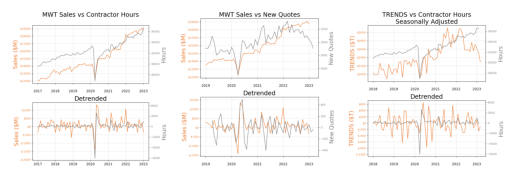

In [56]:
'''
import matplotlib.image as mpimg
fig, axs = plt.subplots(1,3, )
for i, ax in enumerate(axs.flat):
    ax.set_axis_off()
    filename='Output/plot' + str(i+1) + '.png'
    ax.imshow(mpimg.imread(filename))
plt.subplots_adjust(wspace=0.05)    
plt.savefig('Output/master.png')
plt.show()
'''